In [1]:
import os
os.chdir('/home/nlpsomnath/nationwide_pipeline/qyk_troubleshooting/htrdata/')

In [2]:
from src.utils_augment import *
from src.clean_lines import *

In [145]:
wk_dir='/home/nlpsomnath/nationwide_pipeline/qyk_troubleshooting/htrdata/'

In [194]:
file='crowdsource/extracted/111003/$9,900,000.jpg'
patchFile='070473355 - Approved Example EY_Redacted-2-aligned-Unnamed5.jpg'
#patchFile='/cropped_patches/nw_horizontal-2/Declined - Handwritten (1)_Redacted-2-aligned-Unnamed2.jpg'

In [213]:
file_path = wk_dir+file
patchFile_path = wk_dir+'cropped_patches/nw_horizontal-2/'+patchFile
imBase = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
imPatch = cv2.imread(patchFile_path, cv2.IMREAD_GRAYSCALE)

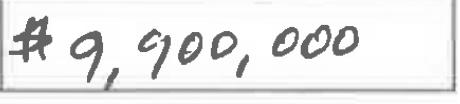

In [214]:
#Original Handwriting Crop
Image.fromarray(imBase)

In [216]:
#Crop cleaning
clean_base=clean_lines(imBase)

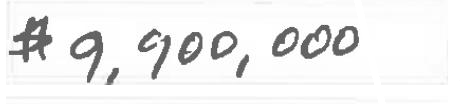

In [217]:
Image.fromarray(clean_base)

In [218]:
#Original Line Patch
Image.fromarray(imPatch)

In [219]:
#Line Patch Normalization (consistent with Base width, and propotional to Base height)
clean_line=horizontal_patch_normalizatoin(imBase,imPatch)

In [220]:
Image.fromarray(clean_line)

In [224]:
# random postion:
nrb, ncb = imBase.shape
centroid = np.random.choice(range(nrb)), int(ncb/2)
print(centroid)

(72, 230)


In [225]:
# merge, if centroid position within middle area, no augmentation would performed. give it some randomness
if centroid[0]<nrb/3 or centroid[0]>nrb/3*2:
    imMerge = merge_patch(im_clean, clean_line, centroid, 20)

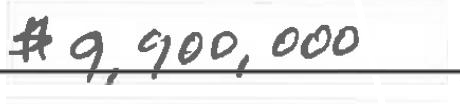

In [226]:
Image.fromarray(imMerge)

In [184]:
im_clean=clean_lines(imBase)
Image.fromarray(im_clean).show()
clean_line=horizontal_patch_normalizatoin(imBase,imPatch)
Image.fromarray(clean_line)
imMerge = merge_patch(im_clean, clean_line, centroid, 100)


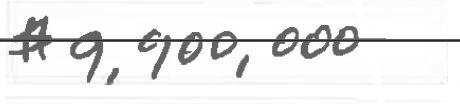

In [185]:
Image.fromarray(imMerge)

### Patch Lines

In [193]:
def remove_background(im, threshold):
  mask = im < threshold
  imMasked = im.copy()
  imMasked[mask] = 0
  return imMasked

def merge_patch(imBase, imPatch, centroid, threshold=20):
  '''Takes imPatch and superimpose on imBase at centroid. Returns modified image'''

  imBase, imPatch = 255-imBase, 255-imPatch # invert images fro processing
  nrb, ncb = imBase.shape
  nrp, ncp = imPatch.shape

  # make white areas of imPatch transparent
  imPatchMasked = remove_background(imPatch, threshold)

  # get difference of centroids between base and patch
  centroidPatch = np.array([int(dim/2) for dim in imPatchMasked.shape])
  delta = np.array(centroid) - centroidPatch

  # add difference of centroids to the x,y position of patch
  cc, rr = np.meshgrid(np.arange(ncp), np.arange(nrp))
  rr = rr + delta[0]
  cc = cc + delta[1]

  # remove all parts of patch image that would expand base image
  keep = reduce(np.logical_and, [rr>=0, rr<nrb, cc>=0, cc<ncb])
  nrk, nck = np.max(rr[keep])-np.min(rr[keep])+1, np.max(cc[keep])-np.min(cc[keep])+1
  imPatchKeep = imPatchMasked[keep]


  # merge base and patch by taking maximum pixel at each position
  imMerge = imBase.copy()
  imBaseCrop = imBase.copy()
  imBaseCrop = imBaseCrop[rr[keep], cc[keep]]
  imMerge[rr[keep], cc[keep]] = np.maximum(imBaseCrop, imPatchKeep)

  return 255-imMerge # invert back


def horizontal_patch_normalizatoin(imBase,imPatch,threshold=20):
    imBase_, imPatch_ = 255-imBase, 255-imPatch # invert images fro processing
    nrb, ncb = imBase_.shape
    #nrp, ncp = imPatch.shape

    # make white areas of imPatch transparent
    imPatchMasked = remove_background(imPatch_, threshold)
    h_arr=np.sum(imPatchMasked,0)
    v_arr=np.sum(imPatchMasked,1)
    clean_line=imPatchMasked[v_arr!=0][:,h_arr!=0]
    nrp,ncp=clean_line.shape
    clean_line_resized=cv2.resize(clean_line,(ncp,int(np.ceil(nrb*v_scale))))
    h_scale=ncb/ncp
    hs_int=int(h_scale)
    hs_dec=h_scale-hs_int
    line_patch=255-np.concatenate((np.repeat(clean_line_resized,hs_int,axis=1),clean_line_resized[:,:int(np.ceil(ncp*hs_dec))]),axis=1)
    return line_patch

def clean_lines(cv_img):
    cv_img_copy=cv_img.copy()
    #gray = cv2.cvtColor(cv_img_copy,cv2.COLOR_BGR2GRAY)
    gray=cv_img_copy.copy()
    gray = cv2.GaussianBlur(gray,(3,3),0)
    height,width=gray.shape
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    minLineLength = 30
    maxLineGap = 15
    lines = cv2.HoughLinesP(edges,1,np.pi/180,45,minLineLength,maxLineGap)
    for line in lines:
        x1,y1,x2,y2=line[0]
        if np.abs(x2-x1)>minLineLength:
            cv2.line(cv_img_copy,(0,y1),(width,y2),255,6) #Grey
        else:
            cv2.line(cv_img_copy,(x1,0),(x2,height),255,6)
    return cv_img_copy 